In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns # For nicer plots
import numpy as np
import json # For loading aggregated_metrics.json
import re # For parsing experiment names
from pathlib import Path # For calculate_metrics_from_full_data
import ast # For calculate_metrics_from_full_data

# Configure matplotlib for better display
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For higher resolution plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors) # Use tab10 color palette
# sns.set_theme(style="whitegrid") # Optionally use a seaborn theme for styling

# --- Configuration (from user) ---
# Define the models and their respective ROOT paths (before dataset name)
models_config = {
    "QwQ-32B": "/home/users/ntu/chong032/slimsc/prune/results/QwQ-32B/",
    "R1-Distill-Qwen-14B": "/home/users/ntu/chong032/slimsc/prune/results/R1-Distill-Qwen-14B/",
}

# Define the benchmark datasets to process
datasets_to_process = ["gpqa_diamond", "aime", "aqua_rat"]

# --- Paths for this specific request ---
# These are the specific paths the user wants to process for now.
# Make sure these paths are correct and accessible from your Jupyter notebook environment.
experiment_paths = [
    f"{models_config["R1-Distill-Qwen-14B"]}gpqa_diamond/diversity_n64_thresh0.95_delay20",
    f"{models_config["R1-Distill-Qwen-14B"]}gpqa_diamond/diversity_n64_thresh0.98_delay20",
    f"{models_config["R1-Distill-Qwen-14B"]}gpqa_diamond/sc_1_control",
    f"{models_config["R1-Distill-Qwen-14B"]}gpqa_diamond/sc_64_control"
]

# Base path (if your experiment_paths are relative) - adjust if necessary
# If paths above are absolute, this can be an empty string or removed.
# For example, if the notebook is in a parent directory of 'slimsc':
# CWD_OVERRIDE = "/path/to/your/notebook_directory_parent" 
# os.chdir(CWD_OVERRIDE) # Uncomment and set if paths are relative to a specific base

In [26]:
def parse_experiment_name(exp_name):
    """
    Parses an experiment name string to extract strategy, n_chains, threshold, and delay.
    Example input: 'diversity_n64_thresh0.95_delay20' or 'sc_64_control'.
    """
    info = {'name': exp_name, 'type': None, 'strategy': None, 
            'n_chains': None, 'threshold': None, 'delay': None, 'strategy_label': exp_name}

    sc_control_match = re.match(r"sc_(\d+)_control", exp_name)
    if sc_control_match:
        info['type'] = 'control'
        info['strategy'] = 'sc_control'
        info['n_chains'] = int(sc_control_match.group(1))
        info['strategy_label'] = f"SC-{info['n_chains']} (Control)"
        return info

    pruning_match = re.match(r"([a-zA-Z0-9]+)_n(\d+)_thresh(\d+\.?\d*)_delay(\d+)", exp_name)
    if pruning_match:
        info['type'] = 'pruning'
        info['strategy'] = pruning_match.group(1)
        info['n_chains'] = int(pruning_match.group(2))
        info['threshold'] = float(pruning_match.group(3))
        info['delay'] = int(pruning_match.group(4))
        info['strategy_label'] = f"{info['strategy'].capitalize()} (N{info['n_chains']}, D{info['delay']})"
        return info
    
    print(f"Warning: Could not parse experiment name: {exp_name}")
    return None

# --- Helper Function for Full Data Metric Calculation (User Provided) ---
def clean_answer_for_calc(ans): # Renamed to avoid conflict if global clean_answer exists
    s = str(ans).strip()
    try:
        return float(s)
    except ValueError:
        if len(s) > 1 and s[0].isalpha() and not s[1].isalnum():
            return s[0].upper()
        return s.upper()

def calculate_metrics_from_full_data(csv_path: Path) -> dict:
    """
    Calculates % Correct Answer Voted (Overall Accuracy) (from mean of final_score),
    % Correct in Individual Answer Candidates, and Voting Efficiency
    from the full data in an evaluation_summary.csv.
    """
    results = {
        "overall_accuracy_calc_perc": float("NaN"), # As percentage
        "perc_correct_in_individual_answers": float("NaN"),
        "voting_efficiency": float("NaN"),
    }

    if not csv_path.exists():
        print(f"Warning: Evaluation summary file not found at {csv_path}")
        return results
    try:
        df = pd.read_csv(csv_path)
        if df.empty:
            print(f"Warning: {csv_path.name} is empty.")
            return results

        # --- Calculate % Correct Answer Voted (Overall Accuracy from final_score mean) ---
        if 'final_score' in df.columns and not df.empty:
            accuracy_from_final_score = pd.to_numeric(df['final_score'], errors='coerce').mean()
            if pd.notna(accuracy_from_final_score):
                 results['overall_accuracy_calc_perc'] = accuracy_from_final_score * 100
            else:
                print(f"Warning: Final score column in {csv_path.name} contains non-numeric values or is all NaN.")
        else:
            print(f"Warning: 'final_score' column not found or data is empty in {csv_path.name}.")

        # --- Calculate % Correct in Individual Answer Candidates ---
        correct_present_count = 0
        total_rows_parsable_individual = 0
        if 'individual_answers_str' in df.columns and 'correct_answer' in df.columns:
             for _, row in df.iterrows():
                try:
                    current_correct_answer_cleaned = clean_answer_for_calc(row['correct_answer'])
                    individual_answers_str = row['individual_answers_str']
                    if pd.isna(individual_answers_str) or not str(individual_answers_str).strip():
                        individual_answers_list_cleaned = []
                    else:
                        raw_list = ast.literal_eval(str(individual_answers_str))
                        individual_answers_list_cleaned = [clean_answer_for_calc(ans) for ans in raw_list]
                    if current_correct_answer_cleaned in individual_answers_list_cleaned:
                        correct_present_count += 1
                    total_rows_parsable_individual += 1
                except (SyntaxError, ValueError) as e:
                     # print(f"Warning: Could not parse ind_answers in {csv_path.name} iter: {row.get('iteration', 'N/A')}. Error: {e}")
                     pass 
                except Exception as e:
                    print(f"Warning: Error processing row for ind answers in {csv_path.name} iter: {row.get('iteration', 'N/A')}: {e}")
             if total_rows_parsable_individual > 0:
                  results['perc_correct_in_individual_answers'] = (correct_present_count / total_rows_parsable_individual) * 100
        else:
            print(f"Warning: Missing 'individual_answers_str' or 'correct_answer' in {csv_path.name}")

        # --- Calculate Voting Efficiency ---
        acc_perc = results.get('overall_accuracy_calc_perc')
        perc_ind = results.get('perc_correct_in_individual_answers')
        if pd.notna(acc_perc) and pd.notna(perc_ind):
             if perc_ind > 0:
                  results['voting_efficiency'] = (acc_perc / perc_ind) * 100 # Efficiency of percentages
             elif perc_ind == 0 and acc_perc == 0: # If no correct candidates and 0 accuracy, define as 0 or NaN. Let's use 0.
                  results['voting_efficiency'] = 0.0
             elif perc_ind == 0 and acc_perc > 0: # Should not happen if logic is correct (accuracy implies correct candidate)
                  results['voting_efficiency'] = float("NaN") # Or some indicator of impossibility
                  print(f"Warning: Voting efficiency calculation anomaly in {csv_path.name} (Acc > 0, Ind_Present = 0).")
             else: # perc_ind is 0
                  results['voting_efficiency'] = 0.0
        # print(f"Debug: Final calculated metrics for {csv_path.name}: {results}") # User's debug print
    except Exception as e:
        print(f"An unexpected error occurred while processing {csv_path}: {e}")
    return results

In [34]:
all_results_data = []
for path_str in experiment_paths:
    path = Path(path_str) 
    exp_name = path.name
    parsed_info = parse_experiment_name(exp_name)
    
    if not parsed_info:
        print(f"Skipping path due to parsing error: {path_str}")
        continue
    
    current_data = {'path': path_str, **parsed_info}
    
    eval_summary_path = path / "evaluation_summary.csv"
    try:
        df_eval = pd.read_csv(eval_summary_path)
        current_data['accuracy'] = pd.to_numeric(df_eval['final_score'], errors='coerce').mean()
        if pd.isna(current_data['accuracy']):
             print(f"Warning: 'accuracy' (from final_score mean) is NaN for {exp_name}.")
    except FileNotFoundError:
        # print(f"File not found: {eval_summary_path} (for {exp_name})") # Less verbose
        current_data['accuracy'] = np.nan
    except Exception as e:
        print(f"Error reading {eval_summary_path} for {exp_name} (accuracy): {e}")
        current_data['accuracy'] = np.nan

    agg_metrics_path = path / "aggregated_metrics.json"
    metrics_to_load_from_json = [
        "mean_total_completion_tokens_per_question",
        "mean_max_kv_cache_usage_per_question_perc", # This is the raw proportion (0-1)
        "mean_processing_duration_sec_per_question"
    ]
    try:
        with open(agg_metrics_path, 'r') as f:
            agg_metrics_content = json.load(f).get("metrics", {})
        
        for metric_key in metrics_to_load_from_json:
            value = agg_metrics_content.get(metric_key)
            current_data[metric_key] = value # Will be converted to numeric later
            
        if parsed_info['type'] == 'pruning':
            current_data['mean_active_chains'] = agg_metrics_content.get("mean_chains_completed_stream_for_voting_per_question")
        elif parsed_info['type'] == 'control':
            current_data['mean_active_chains'] = agg_metrics_content.get("mean_chains_received_per_question")
        else:
            current_data['mean_active_chains'] = None # Ensure key exists
            
    except FileNotFoundError:
        # print(f"File not found: {agg_metrics_path} (for {exp_name})") # Less verbose
        for key in metrics_to_load_from_json: current_data[key] = np.nan
        current_data['mean_active_chains'] = np.nan
    except Exception as e:
        print(f"Error reading {agg_metrics_path} for {exp_name} (agg_metrics): {e}")
        for key in metrics_to_load_from_json: current_data[key] = np.nan
        current_data['mean_active_chains'] = np.nan

    additional_metrics = calculate_metrics_from_full_data(eval_summary_path)
    current_data.update(additional_metrics)
            
    all_results_data.append(current_data)

df_results = pd.DataFrame(all_results_data)

# --- Robust Numeric Conversion ---
numeric_cols_to_convert = [
    "accuracy", # from final_score.mean()
    "mean_total_completion_tokens_per_question",
    "mean_max_kv_cache_usage_per_question_perc", # Original proportion from JSON
    "mean_processing_duration_sec_per_question",
    "mean_active_chains",
    "overall_accuracy_calc_perc", # Calculated by user function (already percentage)
    "perc_correct_in_individual_answers", # Calculated by user function
    "voting_efficiency" # Calculated by user function
]

for col in numeric_cols_to_convert:
    if col in df_results.columns:
        df_results[col] = pd.to_numeric(df_results[col], errors='coerce')
    else:
        print(f"Development warning: Column '{col}' expected for numeric conversion was not found in df_results. Creating as NaN.")
        df_results[col] = np.nan # Ensure column exists to prevent KeyErrors downstream

# Create the KV cache plot column (scaled to 0-100) AFTER source column is numeric
if 'mean_max_kv_cache_usage_per_question_perc' in df_results.columns:
    df_results['mean_max_kv_cache_usage_per_question_plot_perc'] = df_results['mean_max_kv_cache_usage_per_question_perc'] * 100
else:
    # This case should be handled by the loop above, but as a safeguard:
    df_results['mean_max_kv_cache_usage_per_question_plot_perc'] = np.nan


print("\n--- Loaded and Parsed Data Overview (Post Numeric Conversion) ---")
# Display a sample of relevant columns to check dtypes and values
cols_to_display = ['name', 'type', 'threshold', 'accuracy', 
                   'mean_total_completion_tokens_per_question', 
                   'mean_max_kv_cache_usage_per_question_perc', # Original proportion
                   'mean_max_kv_cache_usage_per_question_plot_perc', # Scaled percentage
                   'overall_accuracy_calc_perc']
# Filter to existing columns before display to avoid KeyError if a col was never created
cols_to_display = [col for col in cols_to_display if col in df_results.columns]
display(df_results[cols_to_display].head())
# For more thorough check:
# display(df_results.info())


--- Loaded and Parsed Data Overview (Post Numeric Conversion) ---


,name,type,threshold,accuracy,mean_total_completion_tokens_per_question,mean_max_kv_cache_usage_per_question_perc,mean_max_kv_cache_usage_per_question_plot_perc,overall_accuracy_calc_perc
0,diversity_n64_thresh0.95_delay20,pruning,0.95,0.621212,200499.101010,0.822826,82.282551,62.121212
1,diversity_n64_thresh0.98_delay20,pruning,0.98,0.616162,235143.838384,0.847162,84.716175,61.616162
2,sc_1_control,control,NaN,0.595960,6389.300000,0.031100,3.110000,59.595960
3,sc_64_control,control,NaN,0.636364,415209.200000,0.861000,86.100000,63.636364


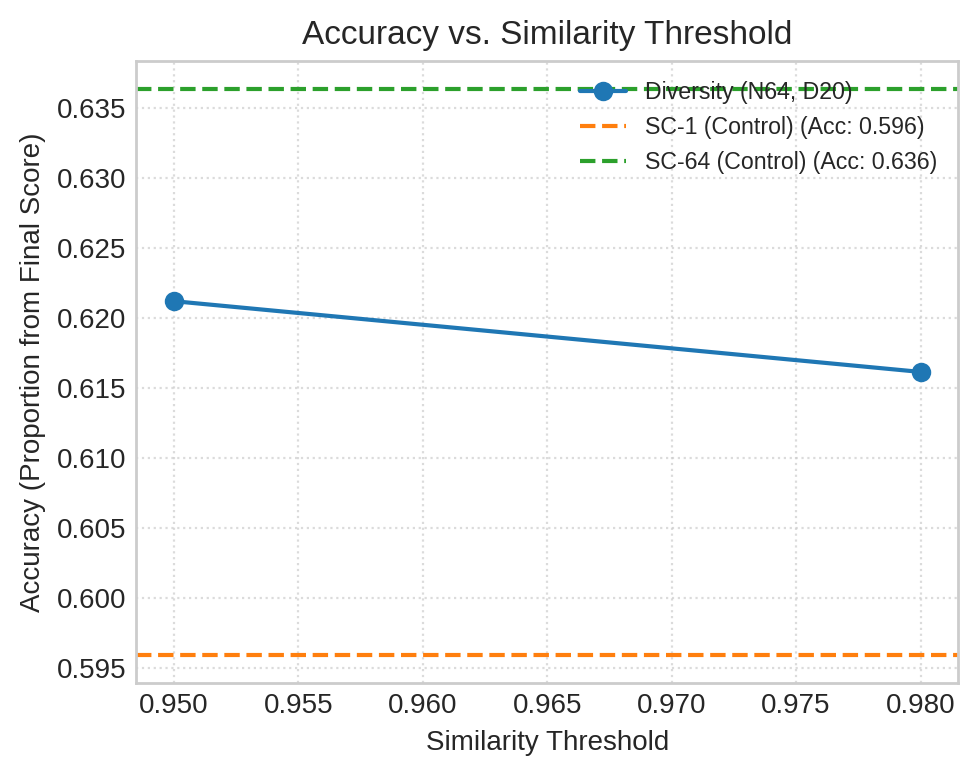

In [35]:
plt.figure(figsize=(5, 4))
ax = plt.gca()

df_pruning = df_results[df_results['type'] == 'pruning'].copy()
df_control = df_results[df_results['type'] == 'control'].copy()

# Get color cycle
color_cycle = plt.cm.tab10.colors
color_idx = 0

# Plot pruning strategies
unique_pruning_labels = sorted(df_pruning['strategy_label'].unique())
for label in unique_pruning_labels:
    group_data = df_pruning[df_pruning['strategy_label'] == label].sort_values(by='threshold')
    if not group_data.empty and group_data['accuracy'].notna().any():
        ax.plot(group_data['threshold'], group_data['accuracy'], marker='o', linestyle='-', 
                 label=label, color=color_cycle[color_idx % len(color_cycle)])
        color_idx += 1

# Plot SC controls
unique_control_labels = sorted(df_control['strategy_label'].unique())
for label in unique_control_labels:
    row = df_control[df_control['strategy_label'] == label].iloc[0]
    if pd.notna(row['accuracy']):
        ax.axhline(y=row['accuracy'], linestyle='--', 
                    label=f"{label} (Acc: {row['accuracy']:.3f})",
                    color=color_cycle[color_idx % len(color_cycle)])
        color_idx += 1

all_thresholds = df_pruning['threshold'].dropna()
if not all_thresholds.empty:
    min_x, max_x = (all_thresholds.min(), all_thresholds.max())
    padding = (max_x - min_x) * 0.05 if max_x > min_x else 0.01
    plt.xlim(min_x - padding, max_x + padding)
else:
    plt.xlim(0.85, 1.0)

ax.set_xlabel("Similarity Threshold")
ax.set_ylabel("Accuracy (Proportion from Final Score)")
ax.set_title("Accuracy vs. Similarity Threshold")
ax.legend(loc='best', fontsize='small')
ax.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

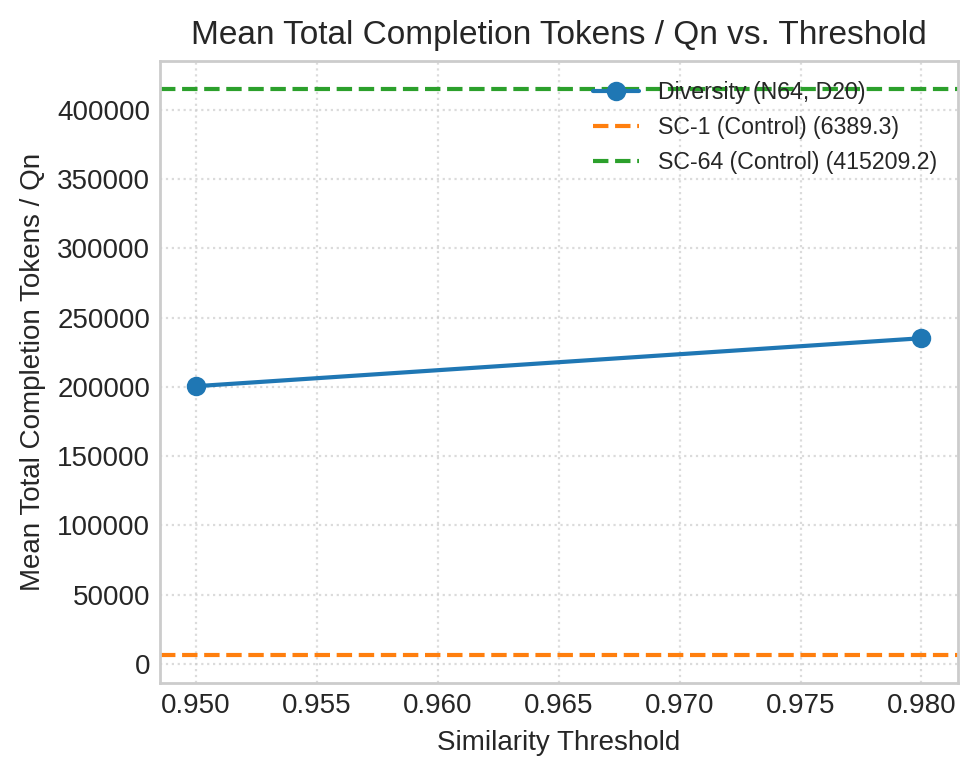

In [36]:
metric_key = "mean_total_completion_tokens_per_question"
metric_label = "Mean Total Completion Tokens / Qn"

plt.figure(figsize=(5, 4))
ax = plt.gca()
color_idx = 0
color_cycle = plt.cm.tab10.colors

# Pruning strategies
df_pruning = df_results[df_results['type'] == 'pruning'].copy()
unique_pruning_labels = sorted(df_pruning['strategy_label'].unique())
for label in unique_pruning_labels:
    group_data = df_pruning[df_pruning['strategy_label'] == label].sort_values(by='threshold')
    if not group_data.empty and group_data[metric_key].notna().any():
        ax.plot(group_data['threshold'], group_data[metric_key], marker='o', linestyle='-', 
                 label=label, color=color_cycle[color_idx % len(color_cycle)])
        color_idx += 1

# SC controls
df_control = df_results[df_results['type'] == 'control'].copy()
unique_control_labels = sorted(df_control['strategy_label'].unique())
for label in unique_control_labels:
    row = df_control[df_control['strategy_label'] == label].iloc[0]
    if pd.notna(row[metric_key]):
        ax.axhline(y=row[metric_key], linestyle='--', 
                    label=f"{label} ({row[metric_key]})",
                    color=color_cycle[color_idx % len(color_cycle)])
        color_idx += 1
        
all_thresholds = df_pruning['threshold'].dropna()
if not all_thresholds.empty:
    min_x, max_x = (all_thresholds.min(), all_thresholds.max())
    padding = (max_x - min_x) * 0.05 if max_x > min_x else 0.01
    plt.xlim(min_x - padding, max_x + padding)
else:
    plt.xlim(0.85, 1.0)

ax.set_xlabel("Similarity Threshold")
ax.set_ylabel(metric_label)
ax.set_title(f"{metric_label} vs. Threshold")
ax.legend(loc='best', fontsize='small')
ax.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
# plt.savefig(f"{metric_key}_vs_threshold.png", dpi=300) # Uncomment to save
plt.show()

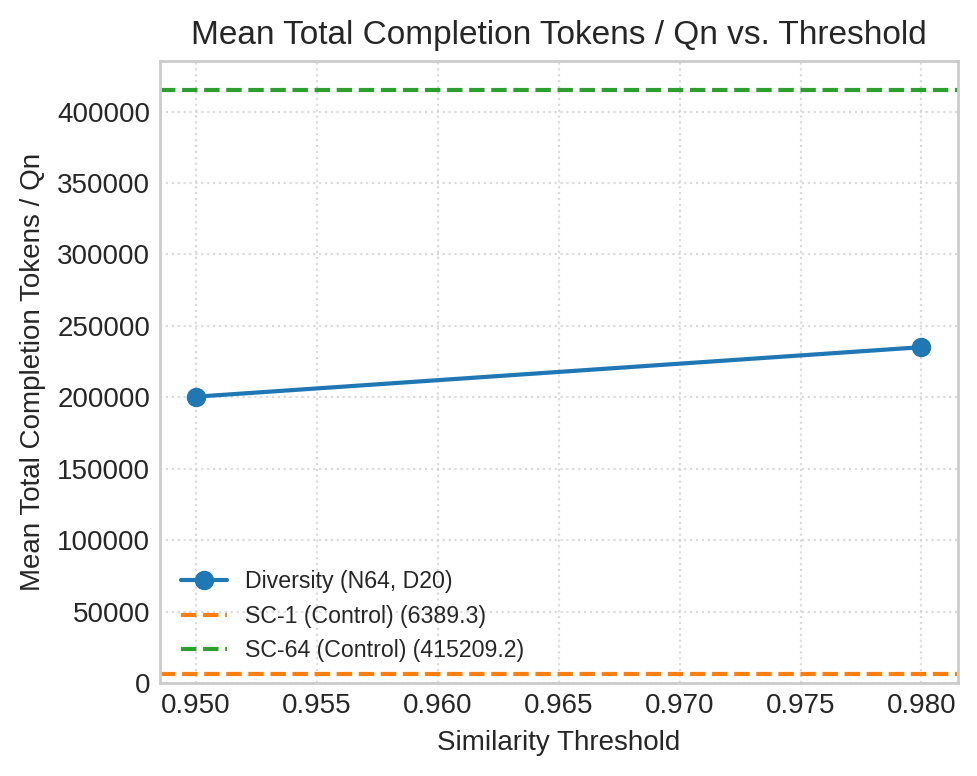

In [44]:
metric_key = "mean_total_completion_tokens_per_question"
metric_label = "Mean Total Completion Tokens / Qn"

plt.figure(figsize=(5, 4))
ax = plt.gca()
color_idx = 0
color_cycle = plt.cm.tab10.colors # Ensure fresh color cycle or manage globally if needed

# Pruning strategies
df_pruning_plot = df_results[df_results['type'] == 'pruning'].copy()
# Ensure thresholds are sorted for line plotting
unique_pruning_labels_plot = sorted(df_pruning_plot['strategy_label'].unique())
for label in unique_pruning_labels_plot:
    group_data = df_pruning_plot[df_pruning_plot['strategy_label'] == label].sort_values(by='threshold')
    if not group_data.empty and group_data[metric_key].notna().any():
        ax.plot(group_data['threshold'], group_data[metric_key], marker='o', linestyle='-', 
                 label=label, color=color_cycle[color_idx % len(color_cycle)], zorder=5) # zorder to bring lines to front
        color_idx += 1

# SC controls
df_control_plot = df_results[df_results['type'] == 'control'].copy()
unique_control_labels_plot = sorted(df_control_plot['strategy_label'].unique())
for label in unique_control_labels_plot:
    # Assuming one row per control strategy label, as threshold doesn't apply
    row = df_control_plot[df_control_plot['strategy_label'] == label].iloc[0] 
    value_to_plot = row[metric_key]
    if pd.notna(value_to_plot): # Value should be numeric after Cell 3 changes
        ax.axhline(y=value_to_plot, linestyle='--', 
                    label=f"{label} ({value_to_plot:.1f})", # Changed to .1f
                    color=color_cycle[color_idx % len(color_cycle)])
        color_idx += 1
        
# X-axis limits based on pruning thresholds
all_thresholds_plot = df_pruning_plot['threshold'].dropna()
if not all_thresholds_plot.empty and all_thresholds_plot.nunique() > 0:
    min_x, max_x = (all_thresholds_plot.min(), all_thresholds_plot.max())
    padding = (max_x - min_x) * 0.05 if max_x > min_x else 0.01 # Add padding if multiple points
    if min_x == max_x : padding = 0.01 # Ensure padding if only one threshold point
    plt.xlim(min_x - padding, max_x + padding)
else: # Default if no pruning thresholds or only one
    # If there's at least one threshold, center around it
    if not all_thresholds_plot.empty:
         plt.xlim(all_thresholds_plot.iloc[0] - 0.015, all_thresholds_plot.iloc[0] + 0.015)
    else: # Fallback if no thresholds at all
         plt.xlim(0.90, 1.0) 


ax.set_ylim(bottom=0) # Ensure y-axis starts at 0

ax.set_xlabel("Similarity Threshold")
ax.set_ylabel(metric_label)
ax.set_title(f"{metric_label} vs. Threshold")
ax.legend(loc='best', fontsize='small')
ax.grid(True, linestyle=':', alpha=0.7) # Dotted grid lines
plt.tight_layout()
# plt.savefig(f"plot_{metric_key}_vs_threshold.png", dpi=300) 
plt.show()

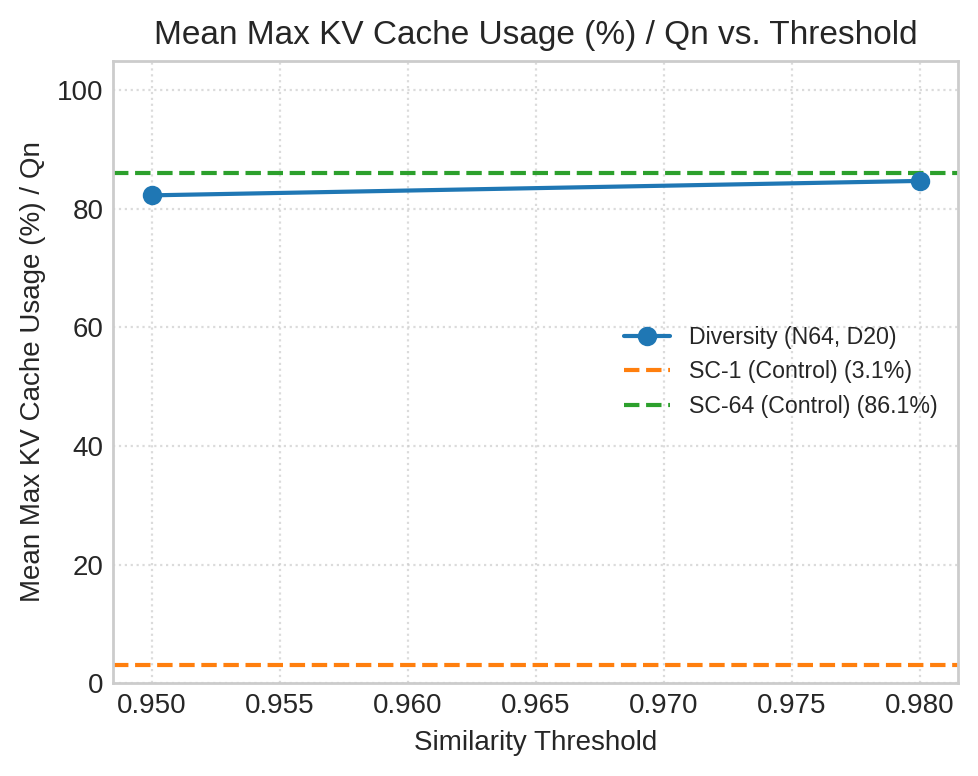

In [45]:
metric_key = "mean_max_kv_cache_usage_per_question_plot_perc" # Using the scaled percentage column
metric_label = "Mean Max KV Cache Usage (%) / Qn"

# Ensure the metric_key column exists and has data
if metric_key not in df_results.columns or df_results[metric_key].isnull().all():
    print(f"Data for '{metric_label}' is not available or all NaN. Skipping plot.")
else:
    plt.figure(figsize=(5, 4))
    ax = plt.gca()
    color_idx = 0
    color_cycle = plt.cm.tab10.colors

    # Pruning strategies
    df_pruning_plot = df_results[df_results['type'] == 'pruning'].copy()
    unique_pruning_labels_plot = sorted(df_pruning_plot['strategy_label'].unique())
    for label in unique_pruning_labels_plot:
        group_data = df_pruning_plot[df_pruning_plot['strategy_label'] == label].sort_values(by='threshold')
        if not group_data.empty and group_data[metric_key].notna().any():
            ax.plot(group_data['threshold'], group_data[metric_key], marker='o', linestyle='-', 
                     label=label, color=color_cycle[color_idx % len(color_cycle)], zorder=5)
            color_idx += 1

    # SC controls
    df_control_plot = df_results[df_results['type'] == 'control'].copy()
    unique_control_labels_plot = sorted(df_control_plot['strategy_label'].unique())
    for label in unique_control_labels_plot:
        row = df_control_plot[df_control_plot['strategy_label'] == label].iloc[0]
        value_to_plot = row[metric_key] 
        if pd.notna(value_to_plot): # Value should be numeric after Cell 3
            ax.axhline(y=value_to_plot, linestyle='--', 
                        label=f"{label} ({value_to_plot:.1f}%)", # Correctly formats numeric value
                        color=color_cycle[color_idx % len(color_cycle)])
            color_idx += 1

    all_thresholds_plot = df_pruning_plot['threshold'].dropna()
    if not all_thresholds_plot.empty and all_thresholds_plot.nunique() > 0:
        min_x, max_x = (all_thresholds_plot.min(), all_thresholds_plot.max())
        padding = (max_x - min_x) * 0.05 if max_x > min_x else 0.01
        if min_x == max_x : padding = 0.01
        plt.xlim(min_x - padding, max_x + padding)
    else:
        if not all_thresholds_plot.empty:
             plt.xlim(all_thresholds_plot.iloc[0] - 0.015, all_thresholds_plot.iloc[0] + 0.015)
        else:
             plt.xlim(0.90, 1.0)

    ax.set_ylim(bottom=0, top=105) # Y-axis for percentage (0-100), with a bit of padding

    ax.set_xlabel("Similarity Threshold")
    ax.set_ylabel(metric_label)
    ax.set_title(f"{metric_label} vs. Threshold")
    ax.legend(loc='best', fontsize='small')
    ax.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    # plt.savefig(f"plot_{metric_key}_vs_threshold.png", dpi=300)
    plt.show()

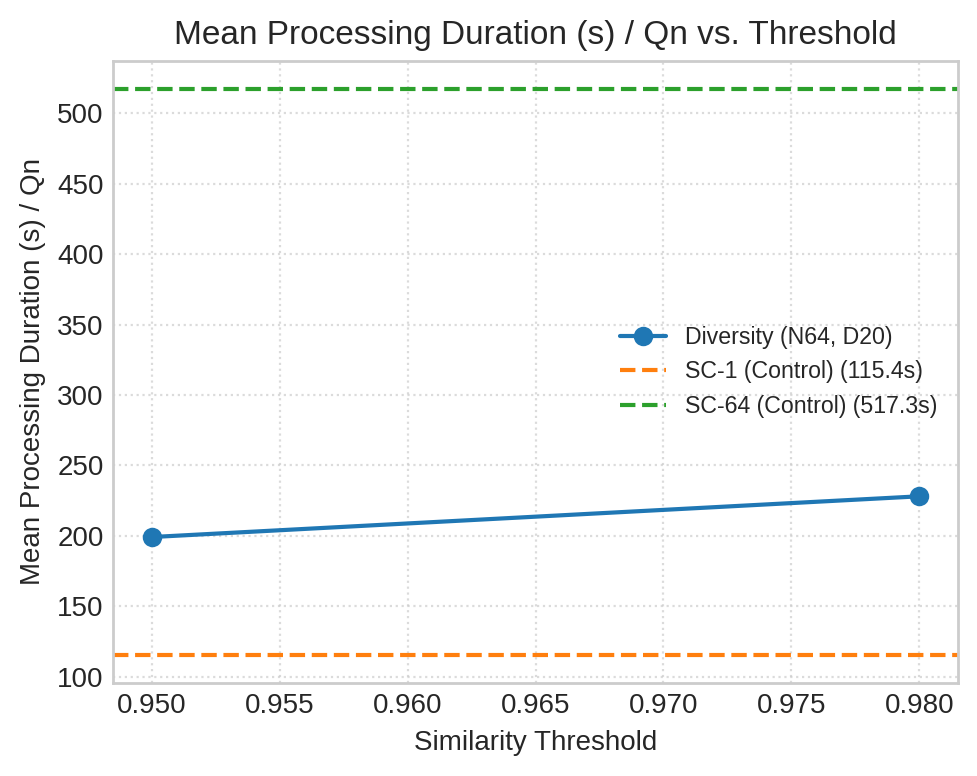

In [46]:
metric_key = "mean_processing_duration_sec_per_question"
metric_label = "Mean Processing Duration (s) / Qn"

plt.figure(figsize=(5, 4))
ax = plt.gca()
color_idx = 0
color_cycle = plt.cm.tab10.colors

# Pruning strategies
df_pruning = df_results[df_results['type'] == 'pruning'].copy()
unique_pruning_labels = sorted(df_pruning['strategy_label'].unique())
for label in unique_pruning_labels:
    group_data = df_pruning[df_pruning['strategy_label'] == label].sort_values(by='threshold')
    if not group_data.empty and group_data[metric_key].notna().any():
        ax.plot(group_data['threshold'], group_data[metric_key], marker='o', linestyle='-', 
                 label=label, color=color_cycle[color_idx % len(color_cycle)])
        color_idx += 1

# SC controls
df_control = df_results[df_results['type'] == 'control'].copy()
unique_control_labels = sorted(df_control['strategy_label'].unique())
for label in unique_control_labels:
    row = df_control[df_control['strategy_label'] == label].iloc[0]
    if pd.notna(row[metric_key]):
        ax.axhline(y=row[metric_key], linestyle='--', 
                    label=f"{label} ({row[metric_key]:.1f}s)",
                    color=color_cycle[color_idx % len(color_cycle)])
        color_idx += 1

all_thresholds = df_pruning['threshold'].dropna()
if not all_thresholds.empty:
    min_x, max_x = (all_thresholds.min(), all_thresholds.max())
    padding = (max_x - min_x) * 0.05 if max_x > min_x else 0.01
    plt.xlim(min_x - padding, max_x + padding)
else:
    plt.xlim(0.85, 1.0)
    
ax.set_xlabel("Similarity Threshold")
ax.set_ylabel(metric_label)
ax.set_title(f"{metric_label} vs. Threshold")
ax.legend(loc='best', fontsize='small')
ax.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
# plt.savefig(f"{metric_key}_vs_threshold.png", dpi=300) # Uncomment to save
plt.show()

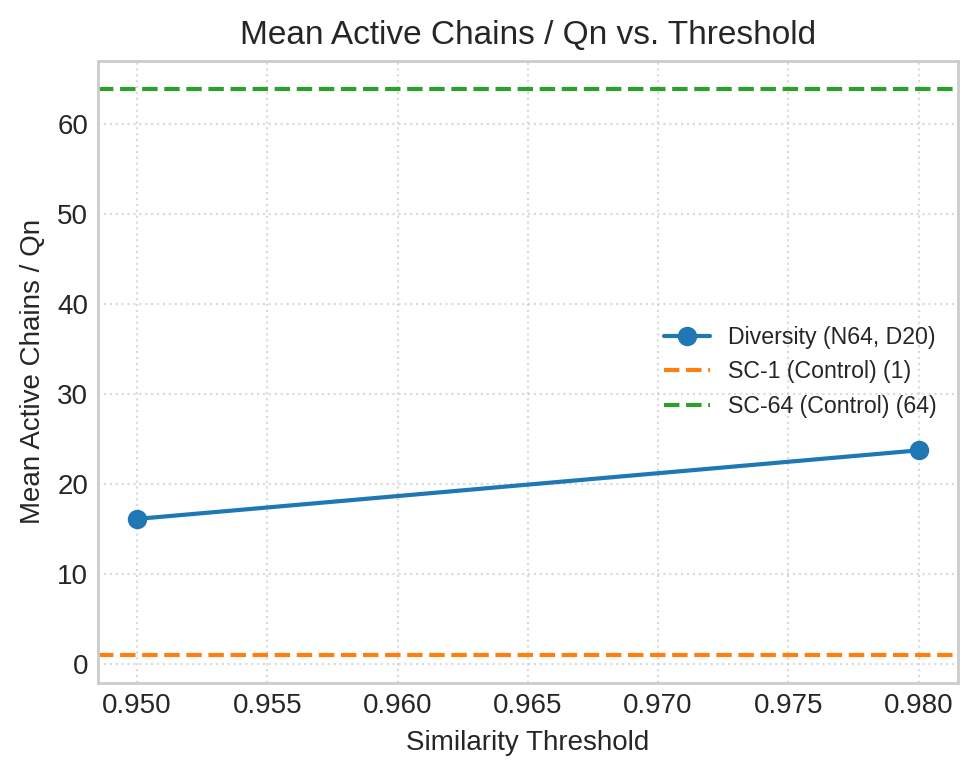

In [48]:
metric_key = "mean_active_chains"
metric_label = "Mean Active Chains / Qn" # Generic label for both types

plt.figure(figsize=(5, 4))
ax = plt.gca()
color_idx = 0
color_cycle = plt.cm.tab10.colors

# Pruning strategies
df_pruning = df_results[df_results['type'] == 'pruning'].copy()
unique_pruning_labels = sorted(df_pruning['strategy_label'].unique())
for label in unique_pruning_labels:
    group_data = df_pruning[df_pruning['strategy_label'] == label].sort_values(by='threshold')
    if not group_data.empty and group_data[metric_key].notna().any():
        ax.plot(group_data['threshold'], group_data[metric_key], marker='o', linestyle='-', 
                 label=label, color=color_cycle[color_idx % len(color_cycle)])
        color_idx += 1

# SC controls
df_control = df_results[df_results['type'] == 'control'].copy()
unique_control_labels = sorted(df_control['strategy_label'].unique())
for label in unique_control_labels:
    row = df_control[df_control['strategy_label'] == label].iloc[0]
    if pd.notna(row[metric_key]):
        ax.axhline(y=row[metric_key], linestyle='--', 
                    label=f"{label} ({row[metric_key]:.0f})",
                    color=color_cycle[color_idx % len(color_cycle)])
        color_idx += 1

all_thresholds = df_pruning['threshold'].dropna()
if not all_thresholds.empty:
    min_x, max_x = (all_thresholds.min(), all_thresholds.max())
    padding = (max_x - min_x) * 0.05 if max_x > min_x else 0.01
    plt.xlim(min_x - padding, max_x + padding)
else:
    plt.xlim(0.85, 1.0)

ax.set_xlabel("Similarity Threshold")
ax.set_ylabel(metric_label)
ax.set_title(f"{metric_label} vs. Threshold")
ax.legend(loc='best', fontsize='small')
ax.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
# plt.savefig(f"{metric_key}_vs_threshold.png", dpi=300) # Uncomment to save
plt.show()

In [50]:
# --- Data Preparation for Triple Bar Chart ---

# Metrics to include in the triple bar chart
metrics_for_triple_bar = {
    "overall_accuracy_calc_perc": "% Correct Voted (Overall Acc.)",
    "perc_correct_in_individual_answers": "% Correct in Candidates",
    "voting_efficiency": "Voting Efficiency (%)"
}
metric_columns_for_triple_bar = list(metrics_for_triple_bar.keys())

# Filter out 'sc_1_control'
# We use the 'name' column which holds the original experiment identifier like 'sc_1_control'
df_for_triple_bar = df_results[df_results['name'] != 'sc_1_control'].copy()

# Check if all required metric columns exist
missing_cols = [col for col in metric_columns_for_triple_bar if col not in df_for_triple_bar.columns]
if missing_cols:
    print(f"Warning: The following columns are missing for the triple bar chart and will be skipped: {missing_cols}")
    # Update metric_columns_for_triple_bar to only include existing columns
    metric_columns_for_triple_bar = [col for col in metric_columns_for_triple_bar if col in df_for_triple_bar.columns]
    # Update metrics_for_triple_bar dictionary as well
    metrics_for_triple_bar = {k: v for k, v in metrics_for_triple_bar.items() if k in metric_columns_for_triple_bar}


if not metric_columns_for_triple_bar:
    print("No valid metric columns found for the triple bar chart. Skipping plot.")
    df_melted_triple_bar = pd.DataFrame() # Empty dataframe
else:
    # Melt the DataFrame to long format for easy plotting with seaborn
    # We'll use 'name' (original experiment id) for the x-axis groups
    df_melted_triple_bar = df_for_triple_bar.melt(
        id_vars=['name', 'strategy_label', 'type'], # Keep these identifiers
        value_vars=metric_columns_for_triple_bar,
        var_name='Metric_Key',
        value_name='Percentage_Value'
    )
    # Map the technical metric key to a more readable label for the legend
    df_melted_triple_bar['Metric_Label'] = df_melted_triple_bar['Metric_Key'].map(metrics_for_triple_bar)

    # Sort for consistent plotting order (optional, but good practice)
    # For example, sort by 'name' then by the order of metrics as defined
    df_melted_triple_bar = df_melted_triple_bar.sort_values(by=['name', 'Metric_Key'])

    print("\n--- Data for Triple Bar Chart (excluding sc_1_control) ---")
    if not df_melted_triple_bar.empty:
        display(df_melted_triple_bar[['name', 'Metric_Label', 'Percentage_Value']].head())
    else:
        print("Melted dataframe is empty.")


--- Data for Triple Bar Chart (excluding sc_1_control) ---


,name,Metric_Label,Percentage_Value
0,diversity_n64_thresh0.95_delay20,% Correct Voted (Overall Acc.),62.121212
3,diversity_n64_thresh0.95_delay20,% Correct in Candidates,71.717172
6,diversity_n64_thresh0.95_delay20,Voting Efficiency (%),86.619718
1,diversity_n64_thresh0.98_delay20,% Correct Voted (Overall Acc.),61.616162
4,diversity_n64_thresh0.98_delay20,% Correct in Candidates,72.222222


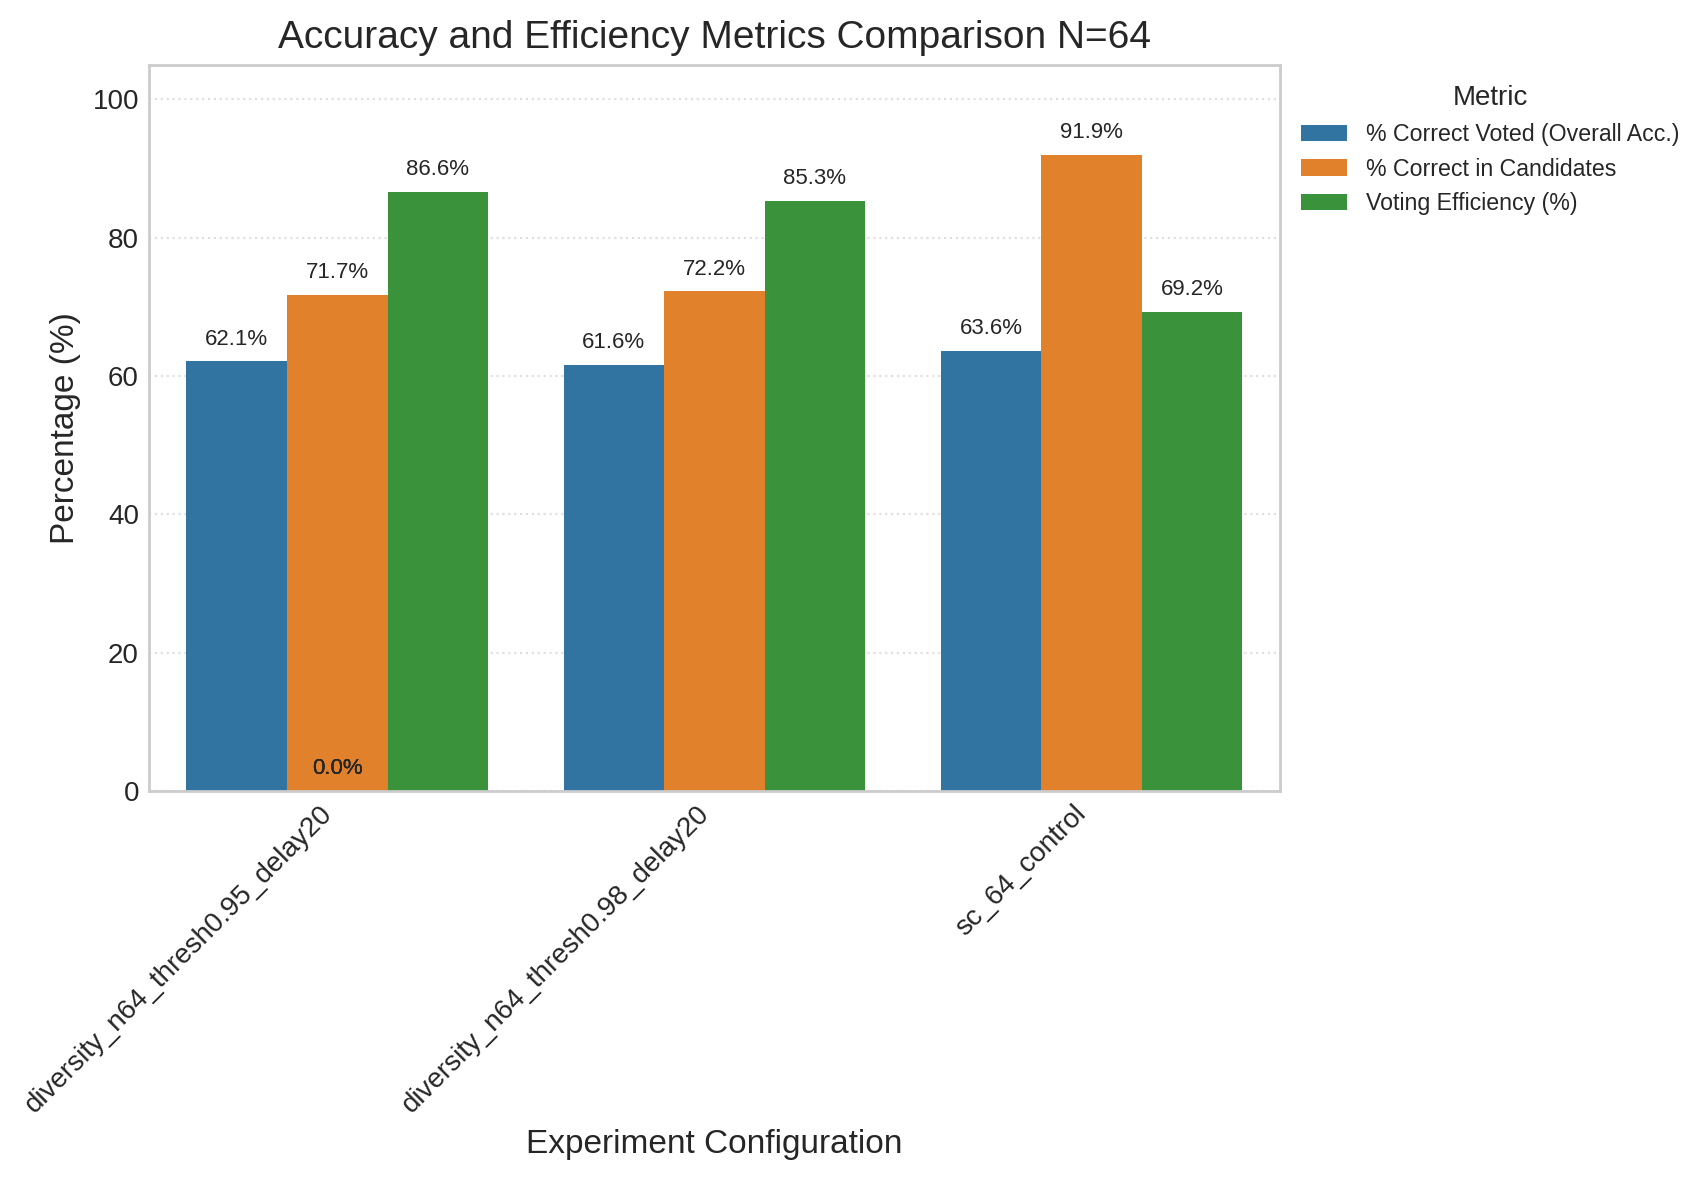

In [56]:
# --- Triple Bar Chart Plotting ---

if df_melted_triple_bar.empty or 'Percentage_Value' not in df_melted_triple_bar.columns:
    print("No data available to plot the triple bar chart.")
else:
    plt.figure(figsize=(10, 6)) # Adjust size as needed

    # Create the bar plot
    # x='name' will group by each experiment configuration
    # hue='Metric_Label' will create the triple bars for each metric
    ax = sns.barplot(
        x='name', 
        y='Percentage_Value', 
        hue='Metric_Label', 
        data=df_melted_triple_bar,
        palette='tab10' # You can choose a different palette
    )

    ax.set_xlabel("Experiment Configuration", fontsize=12)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.set_title("Accuracy and Efficiency Metrics Comparison N=64", fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10) # Rotate x-axis labels for readability
    plt.yticks(fontsize=10)
    
    # Add value annotations to bars
    for p in ax.patches:
        if pd.notna(p.get_height()): # Check for NaN height
            ax.annotate(f"{p.get_height():.1f}%", 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 8), # Offset text slightly above the bar
                        textcoords='offset points', 
                        fontsize=8,
                        rotation=0) # Can add rotation if numbers overlap

    ax.legend(title='Metric', loc='upper left', bbox_to_anchor=(1, 1), fontsize='small') # Place legend outside
    ax.grid(True, linestyle=':', alpha=0.6, axis='y')
    
    # Adjust y-axis limits for better visualization, e.g., ensure 0 is visible and add padding
    min_val = df_melted_triple_bar['Percentage_Value'].min()
    max_val = df_melted_triple_bar['Percentage_Value'].max()
    
    # Set y-limits, ensuring they make sense for percentage data
    y_bottom = 0 if pd.isna(min_val) or min_val >= 0 else min_val * 1.1 # Handle potential negative efficiencies
    y_top = 105 if pd.isna(max_val) or max_val <= 100 else max_val * 1.1 # Pad above max
    if pd.notna(y_bottom) and pd.notna(y_top) and y_top > y_bottom:
        ax.set_ylim(y_bottom, y_top)
    elif pd.notna(max_val): # if only max_val is valid
         ax.set_ylim(bottom=0, top=max_val * 1.15 if max_val > 0 else 10) # default top if max_val is 0 or negative
    else: # fallback
        ax.set_ylim(0, 105)


    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust rect to make space for legend outside
    # plt.savefig("accuracy_efficiency_triple_bar_chart.png", dpi=300) # Uncomment to save
    plt.show()